In [1]:
import os
import numpy as np
import cv2
!pip install mediapipe
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [2]:
# Function to extract pose landmarks from a frame
def get_landmark(frame, pose):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)
    if results.pose_landmarks:
        landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.pose_landmarks.landmark])
        return landmarks
    else:
        return None

In [3]:
# Main function to process video files and assign labels
def video_process(root_folder):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
    dataset = []
    labels = []

    sign_folders = os.listdir(root_folder)
    for sign_folder in sign_folders:
        sign_path = os.path.join(root_folder, sign_folder)
        if os.path.isdir(sign_path):
            for filename in os.listdir(sign_path):
                if filename.endswith('.MOV'):
                    filepath = os.path.join(sign_path, filename)
                    cap = cv2.VideoCapture(filepath)

                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                        landmarks = get_landmark(frame, pose)
                        if landmarks is not None:
                            dataset.append(landmarks)
                            labels.append(sign_folder)
                    cap.release()
                    
    dataset = np.array(dataset)
    labels = np.array(labels)
    np.save('pose_landmarks_dataset.npy', dataset)
    np.save('pose_landmarks_labels.npy', labels)
    pose.close()

In [ ]:
if __name__ == "__main__":
    video_process('/kaggle/input/include/Adjectives_1of8/Adjectives')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729827680.019930    1321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729827680.083520    1321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729827680.128115    1321 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [5]:
# Load the dataset
x = np.load('pose_landmarks_dataset.npy')
y = np.load('pose_landmarks_labels.npy')

In [6]:
x[0]

array([[ 0.48804522,  0.34332821, -0.60569352],
       [ 0.49639684,  0.32307142, -0.58474225],
       [ 0.50148481,  0.32332098, -0.584759  ],
       [ 0.50600356,  0.32398093, -0.58486313],
       [ 0.47754201,  0.3248412 , -0.58535296],
       [ 0.47062844,  0.32658514, -0.58544183],
       [ 0.46449503,  0.32879278, -0.58549827],
       [ 0.51446033,  0.33910868, -0.46264228],
       [ 0.45775276,  0.34610149, -0.46666297],
       [ 0.49964294,  0.3737804 , -0.56138498],
       [ 0.47681263,  0.37546605, -0.56244284],
       [ 0.55738395,  0.50288129, -0.39907786],
       [ 0.42038509,  0.49544892, -0.41369334],
       [ 0.56581622,  0.69080114, -0.41229066],
       [ 0.41551223,  0.70087284, -0.43329164],
       [ 0.57494098,  0.88313276, -0.49369031],
       [ 0.40359646,  0.89318508, -0.51685232],
       [ 0.5813731 ,  0.92966568, -0.53621918],
       [ 0.39398205,  0.94439512, -0.56358778],
       [ 0.56915253,  0.93214804, -0.5644899 ],
       [ 0.40971729,  0.94479257, -0.590

In [7]:
x.shape

(5991, 33, 3)

In [8]:
y[0]

'1. loud'

In [9]:
y.shape

(5991,)

Middle frame index for /kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9451.MOV: 28


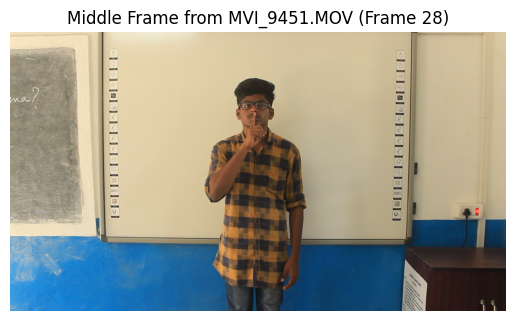

Middle frame index for /kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9297.MOV: 24


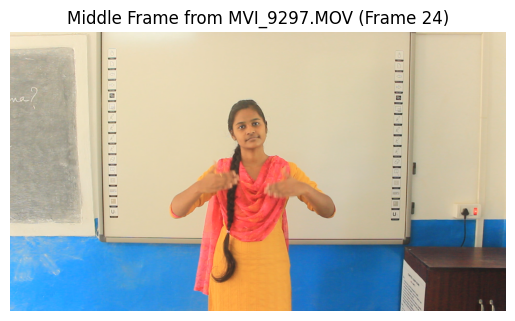

Middle frame index for /kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9372.MOV: 23


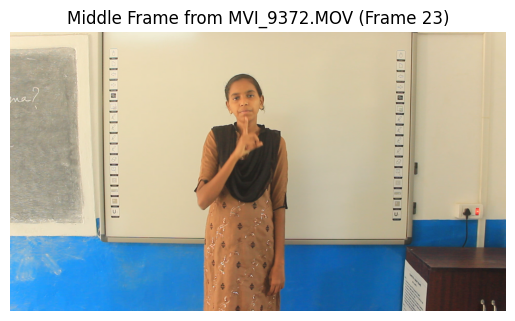

Middle frame index for /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9369.MOV: 24


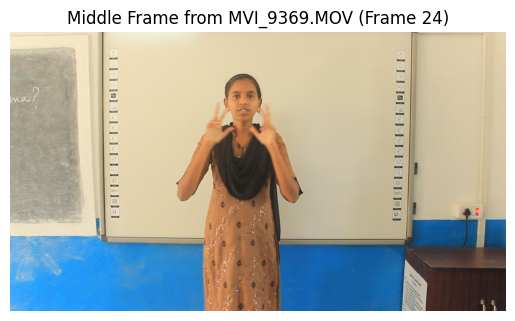

Middle frame index for /kaggle/input/include/Adjectives_1of8/Adjectives/5. Beautiful/MVI_9570.MOV: 39


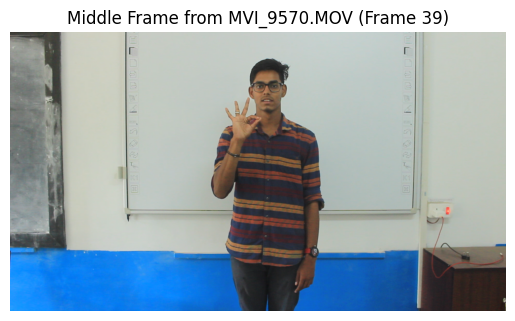

In [11]:
# Main function to process multiple videos from a folder and its subfolders
import random
def visualize_middle_frames_from_videos(folder_path, num_videos=5):
    video_files = []
    
    # Traverse the folder and subfolders to find video files
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.MOV') or file.endswith('.mp4'):
                video_files.append(os.path.join(root, file))
    
    if len(video_files) == 0:
        print(f'No video files found in {folder_path}.')
        return
    
    # Randomly select num_videos from the collected video files
    selected_videos = random.sample(video_files, min(num_videos, len(video_files)))
    
    # Display the middle frame from each selected video
    for video_file in selected_videos:
        visualize_middle_frame_from_video(video_file)

# Example usage
visualize_middle_frames_from_videos('/kaggle/input/include/Adjectives_1of8/Adjectives', num_videos=5)

In [12]:
# Split data into training and testing sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# Initialize label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [32]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=x_train.shape[2], hidden_size=64, batch_first=True, dropout=0.4)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.4)
        self.lstm3 = nn.LSTM(32, 16, batch_first=True, dropout=0.4)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = out[:, -1, :]  # Get last output from the sequence
        out, _ = self.lstm2(out.unsqueeze(1))  # Ensure correct shape
        out = out[:, -1, :]
        out, _ = self.lstm3(out.unsqueeze(1))
        out = out[:, -1, :]
        out = self.fc(out)  # Final output
        return out

In [34]:
# Get the number of classes
num_classes = len(np.unique(y_train_encoded))

# Initialize the model with both input_size and num_classes
model = LSTMModel(num_classes)

# Move the model to the appropriate device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (lstm1): LSTM(3, 64, batch_first=True, dropout=0.4)
  (lstm2): LSTM(64, 32, batch_first=True, dropout=0.4)
  (lstm3): LSTM(32, 16, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=16, out_features=8, bias=True)
)

In [35]:
# Convert training and testing data to tensors
x_train_tensor = torch.Tensor(x_train).to(device)
y_train_tensor = torch.Tensor(y_train_encoded).long().to(device)
x_val_tensor = torch.Tensor(x_val).to(device)
y_val_tensor = torch.Tensor(y_val_encoded).long().to(device)

In [36]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

In [37]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [38]:
# Initialize arrays to store training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 500
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Store training loss and accuracy for the current epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()  # Put the model in evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation during validation
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Store validation loss and accuracy for the current epoch
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# After training, you can access `train_losses`, `val_losses`, `train_accuracies`, and `val_accuracies` arrays.

Epoch [1/500], Train Loss: 1.9958, Train Accuracy: 20.26%, Val Loss: 1.9872, Val Accuracy: 19.68%
Epoch [2/500], Train Loss: 1.9886, Train Accuracy: 20.83%, Val Loss: 1.9858, Val Accuracy: 19.68%
Epoch [3/500], Train Loss: 1.9865, Train Accuracy: 20.26%, Val Loss: 1.9839, Val Accuracy: 19.68%
Epoch [4/500], Train Loss: 1.9866, Train Accuracy: 20.49%, Val Loss: 1.9805, Val Accuracy: 19.68%
Epoch [5/500], Train Loss: 1.9869, Train Accuracy: 20.18%, Val Loss: 1.9914, Val Accuracy: 19.68%
Epoch [6/500], Train Loss: 1.9872, Train Accuracy: 21.22%, Val Loss: 1.9841, Val Accuracy: 19.68%
Epoch [7/500], Train Loss: 1.9871, Train Accuracy: 20.78%, Val Loss: 1.9818, Val Accuracy: 19.68%
Epoch [8/500], Train Loss: 1.9863, Train Accuracy: 20.41%, Val Loss: 1.9863, Val Accuracy: 19.68%
Epoch [9/500], Train Loss: 1.9870, Train Accuracy: 20.43%, Val Loss: 1.9801, Val Accuracy: 19.68%
Epoch [10/500], Train Loss: 1.9872, Train Accuracy: 21.22%, Val Loss: 1.9798, Val Accuracy: 19.68%
Epoch [11/500], Tra

In [44]:
num_epochs = 100
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Store training loss and accuracy for the current epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()  # Put the model in evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation during validation
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Store validation loss and accuracy for the current epoch
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# After training, you can access `train_losses`, `val_losses`, `train_accuracies`, and `val_accuracies` arrays.

Epoch [1/100], Train Loss: 0.4467, Train Accuracy: 81.43%, Val Loss: 0.4959, Val Accuracy: 80.48%
Epoch [2/100], Train Loss: 0.4251, Train Accuracy: 83.14%, Val Loss: 0.5311, Val Accuracy: 78.07%
Epoch [3/100], Train Loss: 0.4671, Train Accuracy: 79.59%, Val Loss: 0.5473, Val Accuracy: 78.23%
Epoch [4/100], Train Loss: 0.4474, Train Accuracy: 81.22%, Val Loss: 0.5438, Val Accuracy: 78.73%
Epoch [5/100], Train Loss: 0.4168, Train Accuracy: 83.16%, Val Loss: 0.6009, Val Accuracy: 76.15%
Epoch [6/100], Train Loss: 0.5643, Train Accuracy: 76.57%, Val Loss: 0.5946, Val Accuracy: 76.06%
Epoch [7/100], Train Loss: 0.4499, Train Accuracy: 81.41%, Val Loss: 0.5126, Val Accuracy: 79.48%
Epoch [8/100], Train Loss: 0.4158, Train Accuracy: 82.35%, Val Loss: 0.5320, Val Accuracy: 78.32%
Epoch [9/100], Train Loss: 0.4002, Train Accuracy: 83.39%, Val Loss: 0.6825, Val Accuracy: 73.98%
Epoch [10/100], Train Loss: 0.4391, Train Accuracy: 82.03%, Val Loss: 0.6029, Val Accuracy: 75.65%
Epoch [11/100], Tra

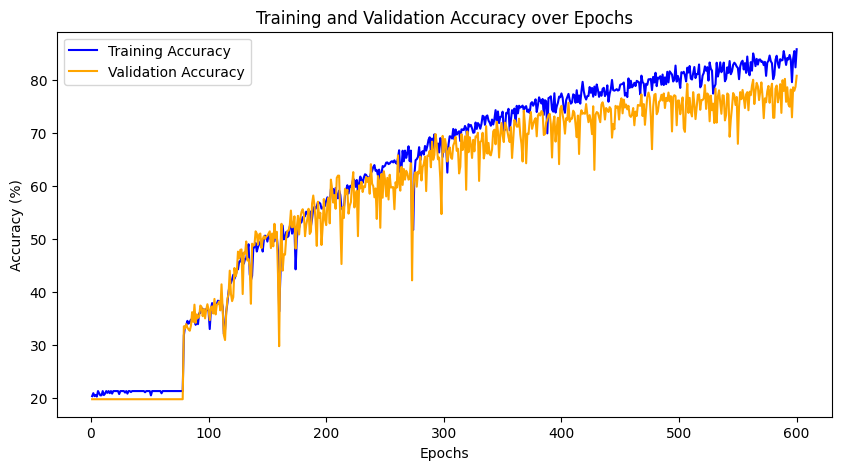

In [48]:
# Assuming you have trained for 600 epochs, but check lengths first
num_epochs = min(len(train_accuracies), len(val_accuracies), 600)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(epochs, train_accuracies[:num_epochs], label='Training Accuracy', color='blue')

# Plot validation accuracy
plt.plot(epochs, val_accuracies[:num_epochs], label='Validation Accuracy', color='orange')

# Labeling the graph
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the graph
plt.show()

In [49]:
# Evaluate model
model.eval()
with torch.no_grad():
    test_outputs = model(x_val_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    
accuracy = accuracy_score(y_val_tensor.cpu(), predicted.cpu())
print(f'Val Accuracy: {accuracy:.4f}')

# Classification Report
print(classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=label_encoder.classes_))

# Visualization of results
metrics = {'Model': ['LSTM'], 'Accuracy': [accuracy]}
metrics_df = pd.DataFrame(metrics)

Val Accuracy: 0.7973
              precision    recall  f1-score   support

     1. loud       0.80      0.77      0.78       253
    2. quiet       0.91      0.92      0.91       236
    3. happy       0.76      0.78      0.77       229
      4. sad       0.77      0.93      0.84        95
5. Beautiful       0.75      0.66      0.70        99
     6. Ugly       0.82      0.80      0.81       119
     7. Deaf       0.76      0.66      0.70        87
    8. Blind       0.69      0.75      0.72        81

    accuracy                           0.80      1199
   macro avg       0.78      0.78      0.78      1199
weighted avg       0.80      0.80      0.80      1199



In [50]:
# Save the model
torch.save(model.state_dict(), 'demo_lstm.pth')

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

In [52]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed
from keras.optimizers import Adam

In [53]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(0.4))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model and store the training history
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val, y_val_encoded), 
                    epochs=600, batch_size=32)

# Extract accuracy and validation accuracy from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')

# Label the graph
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Evaluate the TensorFlow/Keras model on the validation set
loss, tf_keras_val_accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(f'TensorFlow/Keras Model Validation Accuracy: {tf_keras_val_accuracy:.4f}')

# Generate predictions for the validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report for the TensorFlow/Keras model
print(classification_report(y_val_encoded, y_pred_classes, target_names=label_encoder.classes_))

# Visualization of results
metrics = {'Model': ['LSTM (PyTorch)', 'LSTM (TensorFlow/Keras)'], 
           'Accuracy': [accuracy, tf_keras_val_accuracy]}
metrics_df = pd.DataFrame(metrics)

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison (PyTorch vs TensorFlow)')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Save the entire model
model.save('demo2_lstm.h5')